# Linear Trends in Gridded Data

This is a simple example that shows how to detect linear trends in a gridded dataset. 

The example data is the HadCRUT data (`HadCRUT.4.6.0.0.median.nc`), which was obtained from https://crudata.uea.ac.uk/cru/data/temperature/. 

The function `get_trend` takes and input file path, variable name, and optionally a method (explained later). The dataset is opened, and an annual mean is taken. The trend is obtained by fitting a line through the data at each spatial point using the `polyfit` method. The only tricky thing here is that the `get_trend` function returns the coefficients. The slope is given by the first one, while the second one is the constant term (i.e., in $y = mx + b$ )

To check the goodness of fit, we can look at the $r^2$ value using the `get_rsquare` function. To check for trends that are statistically significant from zero, we use a 2-sided t-test. The test is implemented in the function `get_pvalue_by_hand` (so named because I couldn't find a function that would do this for an array of values).  

In [1]:
import numpy as np
import xarray as xr
import geocat.comp as gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import stats




In [18]:

def get_trend(ifil, v, method='xarray', deg=1):
    ds = xr.open_dataset(ifil, decode_times=False)
    if 'time_bnds' in ds:
        correct_time = ds['time_bnds'].mean(dim='nbnd')
        correct_time.attrs = ds['time'].attrs
        ds = ds.assign_coords({"time":correct_time})
    ds = xr.decode_cf(ds)
    if 'longitude' in ds.dims:
        ds = ds.rename({'longitude':'lon'})
    if 'latitude' in ds.dims:
        ds = ds.rename({'latitude':'lat'})
    X = ds[v]
    X = X.groupby('time.year').mean(dim='time')
    X = X.rename({'year':'time'})
    print(f"X coords: {X.coords}")
    print(f"X shape: {X.shape}")
    print(f"X min: {X.min().item()}, max: {X.max().item()}")
    # yearfrac = X.time.dt.year + X.time.dt.month/12
    yearfrac = X.time
    print(f"Time shape: {yearfrac.shape}")
    if method == 'geocat':
        coefs = gc.polynomial.ndpolyfit(yearfrac, X, deg=deg)
    elif method == 'xarray':
        coefs = X.polyfit(dim='time', deg=deg, skipna=True)  # polyfit_coefficients[degree, lat, lon]
    else:
        print(f"ERROR method = {method}")
    return coefs

        
def get_rsquare(dataOrig, coefficients):
    """
    Calculate the coefficient of determination, r^2 for a linear regression.

    dataOrig :: xarray DataArray with a time dimension

    coefficients :: xarray dataset of coefficients for polynomial fit
                    Probably from dataOrig.polyfit(dim='time', deg=1) 

    RETURN
    ------
        rsquared :: the coefficient of determination

    METHOD
    ------
        One minus the ratio of the squared sum of residuals to the total squared sum.
        See: https://en.wikipedia.org/wiki/Coefficient_of_determination
    """
    yhat = xr.polyval(dataOrig.time, coefficients)
    ybar = dataOrig.mean(dim='time')
    ssreg = ((yhat - ybar)**2).sum(dim='time')
    sstot = ((X - ybar)**2).sum(dim='time')
    rsquared = 1 - (ssreg / sstot)
    return rsquared


def get_pvalue_by_hand(dataOrig, coefficients):  
    """
    Calculate the p-value for a two-sided t-test for a linear regression model.
    
    dataOrig :: input data, assumes xarray DataArray with a time dimension
    
    coefficients :: the coefficients of a polynomial fit to dataOrig.
                    For a linear model, coefficients = dataOrig.polyfit(dim='time', deg=1)
                    
    RETURNS
    -------
    pval :: a DataArray of p-values. For a linear fit to dataOrig, the null hypothesis is that
            the slope is zero. Reject the null hypothesis if pval is less than the critical value,
            e.g., pval < pcrit. This is because pval is the probability of getting the derived
            t-statistic from a t-distribution with the same degrees of freedom.
            
            
    Resources
    ---------
     - https://stattrek.com/regression/slope-test.aspx
     - https://www.statology.org/p-value-from-t-score-python/
     - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html
     
    """
    df = len(dataOrig.time) - 2  # degrees of freedom
    yhat = xr.polyval(dataOrig.time, coefficients)['polyfit_coefficients'] # fit model to data
    #  sum of square residuals (SSR) for the model:
    ssreg = ((yhat - dataOrig)**2).sum(dim='time') / df
    # Determine the explained sum of squares (ESS) of the independent variable
    ess = ((dataOrig.time - dataOrig.time.mean())**2).sum(dim='time')
    # standard error of the slope
    stderr = np.sqrt(ssreg / ess)
    # test statistic = slope divided by the standard error
    tvalue = coefficients['polyfit_coefficients'][0,:,:] / stderr  # ASSUMES the first coefficient is the "fit"
    # p-value is probability of getting t-value
    pval = np.zeros(tvalue.values.flatten().shape)
    for i, tval in enumerate(tvalue.values.flatten()):
        pval[i] = stats.t.sf(np.abs(tval), df)*2  # two-sided pvalue = Prob(abs(t)>tt)
    pval = np.reshape(pval, tvalue.shape)
    pval = xr.DataArray(pval, dims=tvalue.dims, coords=tvalue.coords)
    return pval


def map_trend(data, ofil):
    print(f"Trend min: {data.min().item()}, max: {data.max().item()}")
    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Mollweide()})
    lons, lats = np.meshgrid(data.lon, data.lat)
    ax.coastlines()
    ax.set_global()
    # img = ax.pcolormesh(lons, lats, data.values, cmap='plasma_r', rasterized=False)
    img = ax.contourf(lons, lats, data.values, cmap='plasma_r')
    fig.colorbar(img)
    plt.show()
    fig.savefig(ofil, bbox_inches='tight', dpi=200)


def map_rsquared(data, ofil):
    print(f"shape of data is {data.shape}")
    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Mollweide()})
    lons, lats = np.meshgrid(data.lon, data.lat)
    img = ax.pcolormesh(lons, lats, data, cmap='plasma_r', norm=mpl.colors.Normalize(vmin=0,vmax=1), rasterized=True, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_global()
    fig.colorbar(img)
    fig.savefig(ofil, bbox_inches='tight', dpi=200)
    



In [3]:
#
# Data
#
input_file = "/Users/brianpm/Dropbox/Data/HadCRUT/HadCRUT.4.6.0.0.median.nc"

In [4]:
#
# get the trend 
#
tr = get_trend(input_file, "temperature_anomaly", method='xarray')

tr  # Dataset --> tr['polyfit_coefficients'] is what to use. 
    # tr['polyfit_coefficients'] will be (degree: 2, lat: 36, lon: 72) for the HadCRUT data

X coords: Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2015 2016 2017 2018 2019
X shape: (170, 36, 72)
X min: -11.148754119873047, max: 9.656693458557129
Time shape: (170,)


/Users/brianpm/miniconda3/envs/w/lib/python3.9/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


<xarray.Dataset>
Dimensions:               (degree: 2, lat: 36, lon: 72)
Coordinates:
  * degree                (degree) int64 1 0
  * lat                   (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                   (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Data variables:
    polyfit_coefficients  (degree, lat, lon) float64 nan nan ... 20.26 -37.32

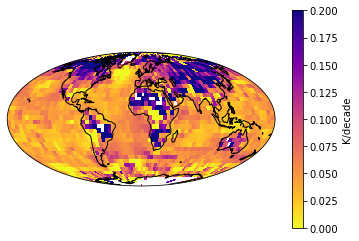

In [5]:
#
# Visualize the trend
#
slope = tr['polyfit_coefficients'][0,:,:]
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Mollweide()})
lons, lats = np.meshgrid(slope.lon, slope.lat)
img = ax.pcolormesh(lons, lats, 10*slope, cmap='plasma_r', norm=mpl.colors.Normalize(vmin=0,vmax=0.2), rasterized=True, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
fig.colorbar(img, label='K/decade')

## global mean time series

Just to show very clearly how this works, we can re-load the data and get the global mean time series and repeat the process of getting the trend.

In [6]:
dsraw = xr.open_dataset(input_file)  # data set from HadCRUT
# rename coordinates
if 'longitude' in dsraw.dims:
    dsraw = dsraw.rename({'longitude':'lon'})
if 'latitude' in dsraw.dims:
    dsraw = dsraw.rename({'latitude':'lat'})
    
Xraw = dsraw['temperature_anomaly']
# Annual means:
Xraw = Xraw.groupby('time.year').mean(dim='time') 
Xraw = Xraw.rename({'year':'time'})


print(f"X coords: {Xraw.coords}")
print(f"X shape: {Xraw.shape}")
print(f"X min: {Xraw.min().item()}, max: {Xraw.max().item()}")

X coords: Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2015 2016 2017 2018 2019
X shape: (170, 36, 72)
X min: -11.148754119873047, max: 9.656693458557129


In [7]:
# apply area weighting
Xw = Xraw.weighted(np.cos(np.radians(Xraw.lat)))

# global mean:
glb =  Xw.mean(dim=("lat","lon"))

# gets the coefficients for the linear fit at each grid point
gtrendfit = glb.polyfit(dim='time', deg=1, skipna=True)  # polyfit_coefficients[degree, lat, lon]

# use polyval to provide the estimated time series (from the linear model)
gfit = xr.polyval(glb.time, gtrendfit)

# directly use the coefficents to make the estimate
hfit = gtrendfit['polyfit_coefficients'][0]*glb.time + gtrendfit['polyfit_coefficients'][1]

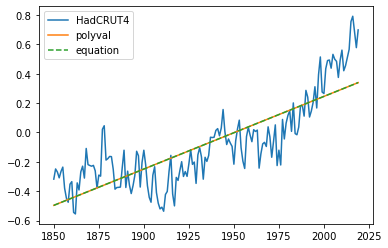

In [8]:
#
# visualize the actual time series along with the two fits (they're the same)
#
fig, ax = plt.subplots()
ax.plot(glb.time, glb, label='HadCRUT4')
ax.plot(glb.time, gfit['polyfit_coefficients'], label='polyval')
ax.plot(glb.time, hfit, linestyle='dashed', label='equation')
ax.legend()

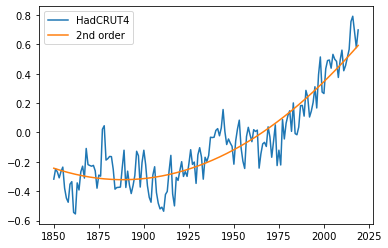

In [9]:
#
# See if a 2nd order polynomial does better
#
# gets the coefficients for the linear fit at each grid point
gtrendfit = glb.polyfit(dim='time', deg=2, skipna=True)  # polyfit_coefficients[degree, lat, lon]

# use polyval to provide the estimated time series (from the linear model)
gfit = xr.polyval(glb.time, gtrendfit)

fig, ax = plt.subplots()
ax.plot(glb.time, glb, label='HadCRUT4')
ax.plot(glb.time, gfit['polyfit_coefficients'], label='2nd order')
ax.legend()

## Significance test

Return to the global data and get the p-values.

In [10]:
pval = get_pvalue_by_hand(Xraw, tr)  # pass the coefficients `tr`, `get_pvalue` will use `polyval` for the comparison.


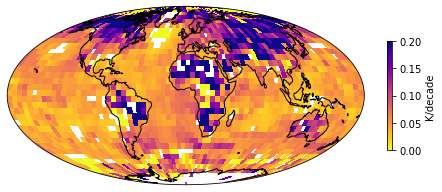

In [11]:
#
# Visualize only significant trends
#
sigtrend = np.where( pval < 0.05, 10.*slope, np.nan)  # multiply by 10 to get degrees / decade
sigtrend = xr.DataArray(sigtrend, dims=("lat","lon"), coords={"lat":Xraw.lat, "lon":Xraw.lon})

fig, ax = plt.subplots(figsize=(8,4), subplot_kw={"projection":ccrs.Mollweide()})
lons, lats = np.meshgrid(sigtrend.lon, sigtrend.lat)
img = ax.pcolormesh(lons, lats, sigtrend, cmap='plasma_r', norm=mpl.colors.Normalize(vmin=0,vmax=0.2), rasterized=True, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
fig.colorbar(img, label='K/decade', shrink=0.5)

## GEOCAT

It would be nice to use GeoCAT for this workflow. The `method` keyword was intended to allow this as an option. I believe the Xarray and GeoCAT functions are very similar, and rely on the same numpy function. There are a couple of issues that I have not been able to work out with GeoCAT:
- locations that have ALL missing data cause an error.
  + in the following cells, I show one way to try to get around it, but I dont think it totally works
- the handling of metadata seems incomplete in GeoCAT; I keep getting dimension names changed to `dim_0`, `dim_1`, etc.


In [19]:

# This does not work because some locations have all missing data
trgc = get_trend(input_file, "temperature_anomaly", method='geocat')

X coords: Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2015 2016 2017 2018 2019
X shape: (170, 36, 72)
X min: -11.148754119873047, max: 9.656693458557129
Time shape: (170,)


TypeError: expected non-empty vector for x

In [133]:

# Attemp to construct a workflow for geocat
# This part repeats what we did in get_trend()

ds = xr.open_dataset(input_file, decode_times=False)
if 'time_bnds' in ds:
    correct_time = ds['time_bnds'].mean(dim='nbnd')
    correct_time.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time":correct_time})
ds = xr.decode_cf(ds)
if 'longitude' in ds.dims:
    ds = ds.rename({'longitude':'lon'})
if 'latitude' in ds.dims:
    ds = ds.rename({'latitude':'lat'})
X = ds['temperature_anomaly']
X = X.groupby('time.year').mean(dim='time')
X = X.rename({'year':'time'})
print(f"X coords: {X.coords}")
print(f"X shape: {X.shape}")
print(f"X min: {X.min().item()}, max: {X.max().item()}")
# yearfrac = X.time.dt.year + X.time.dt.month/12
yearfrac = X.time
print(f"Time shape: {yearfrac.shape}")


X coords: Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2015 2016 2017 2018 2019
X shape: (170, 36, 72)
X min: -11.148754119873047, max: 9.656693458557129
Time shape: (170,)


In [134]:

# anywhere that is all missing should be screened out
# Attempt here is to detect those locations,
# and then construct a `stacked` coordinate for space,
# extract only locations with data,
# calculate the linear model coefficients,
# and rebuild the correctly shaped DataArray

print(f"Orig shape : {X.shape}")
ntim = len(X.time)
allmissing = ntim == np.sum(np.isnan(X), axis=0)  # Boolean Mask

amstack = allmissing.stack(z=("lat","lon"))  # flatten space
# z-Indices where all data is missing
amndx = np.argwhere(~amstack.values)  # provides space indices with data

Xstack = X.stack(z=("lat","lon"))  # data with flattend space
print(f"Stacked shape {Xstack.shape}")
Ystack = Xstack[:,~amstack]  # subset without points that are all missing
print(f"Subset shape {Ystack.shape}")

# Find the coefficients for subset
coefs = gc.polynomial.ndpolyfit(X.time, Ystack.values, deg=1)
# correct the metadata to match Ystack
coefs = coefs.rename({"dim_1":"z"})
coefs = coefs.assign_coords({"z":Ystack['z']})

# Try to put coefficients in the correct position in the full space
result = np.zeros((2, len(amstack))) + np.nan
print(f"result shape should be {result.shape} = {len(X.lat)*len(X.lon)}")
print(f"We have {coefs.shape} coefficients to assign")
result[0,amndx.ravel()] = coefs[0,:].values
result[1,amndx.ravel()] = coefs[1,:].values
# meta data assignment
result = xr.DataArray(result, dims=("coefficient","z"), coords={"z":Xstack.z})
# reshape back to lat-lon space
result = result.unstack()
result
# As shown below, there is something wrong with this method.

Orig shape : (170, 36, 72)
Stacked shape (170, 2592)
Subset shape (170, 2330)
result shape should be (2, 2592) = 2592
We have (2, 2330) coefficients to assign


/Users/brianpm/miniconda3/envs/w/lib/python3.9/site-packages/geocat/comp/polynomial.py:232: RankWarning: Polyfit may be poorly conditioned
  return _ndpolyfit(x, y, axis, deg, rcond, full, w, cov, missing_value)
/Users/brianpm/miniconda3/envs/w/lib/python3.9/site-packages/geocat/comp/polynomial.py:232: RankWarning: Polyfit may be poorly conditioned
  return _ndpolyfit(x, y, axis, deg, rcond, full, w, cov, missing_value)


<xarray.DataArray (coefficient: 2, lat: 36, lon: 72)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 1.87899440e-02,  1.87899440e-02,  1.87899440e-02, ...,
          1.87899440e-02,  1.87899440e-02,  1.87899440e-02],
        ...,
        [ 1.87899440e-02,  1.87899440e-02,  1.87899440e-02, ...,
          1.87899440e-02,  1.87899440e-02,  1.87899440e-02],
        [ 1.87899440e-02,  1.87899440e-02,  1.87899440e-02, ...,
          1.87899440e-02,  1.87899440e-02,  1.87899440e-02],
        [ 1.87899440e-02,  1.87899440e-02,  1.87899440e-02, ...,
          1.87899440e-02,  1.87899440e-02,  1.87899440e-02]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-3.73184514e+01, -3.73184514e+01, -3.73184514e+01, ...,
         -3.73184514e+01, -3.73184514e+01, -3.73184514e+01],
        ...,
        [-3.73184514e+01, -3.73184514e+01, -3.73184514e+01, ...,
         -3.73184514e+01, -3.73184514e+01, -3.73184514e+01],
        [-3.73184514e+01, -3.73184514e+01, -3.73184514e+01, ...,
         -3.73184514e+01, -3.73184514e+01, -3.73184514e+01],
        [-3.73184514e+01, -3.73184514e+01, -3.73184514e+01, ...,
         -3.73184514e+01, -3.73184514e+01, -3.73184514e+01]]])
Coordinates:
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
Dimensions without coordinates: coefficient

In [135]:
# Make the linear fits:
gcfitted = gc.ndpolyval(result, X.time)
gcfitted = gcfitted.rename({"dim_1":"lat", "dim_2":"lon"})
gcfitted = gcfitted.assign_coords({"lat":X.lat, "lon":X.lon})

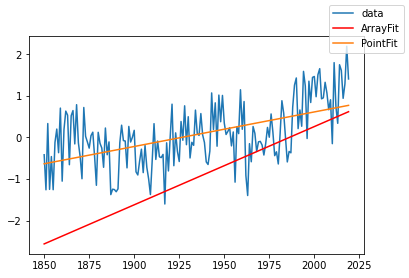

In [138]:
fig, ax = plt.subplots()
t = X.time
paris = X.sel(lat=48.8, lon=2.3, method='nearest')
ax.plot(t, paris, label='data')

ax.plot(t, gcfitted.sel(lat=48.8, lon=2.3, method='nearest'), color='red', label="ArrayFit")
#
#
#
# xrpariscoefs = paris.polyfit(dim='time', deg=1, skipna=True)
# xrparisfit = xr.polyval(t, xrpariscoefs)
# ax.plot(t, xrparisfit['polyfit_coefficients'])
#
# this can't be true ...
#
gcpariscoefs = gc.polynomial.ndpolyfit(t, paris, deg=1)
gcparisfit = gc.polynomial.ndpolyval(gcpariscoefs, t)
ax.plot(t, gcparisfit, label='PointFit')

fig.legend()